<a href="https://colab.research.google.com/github/andrew-veriga/MathForML/blob/master/ConvolutionalCoffieCircles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load libs

In [1]:
import tensorflow as tf
import numpy as np

### Load picture

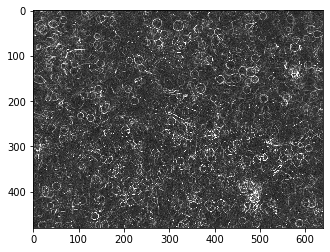

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path='https://github.com/andrew-veriga/MathForML/blob/master/CoffieCircles.png?raw=true'
#img_path='https://drive.google.com/file/d/1Nho1Ed_TnlSzTkJ0v0pc9dfvQH-HOws9/view?usp=sharing'
#img_path='https://www.dropbox.com/s/8naq7w6w2egpl6t/CoffieCircles.png?dl=0'
Image = mpimg.imread(img_path)
plt.imshow(Image)

In [3]:
print(Image.shape)

(480, 640, 4)


###Prepare picture
Convert Image to 2D

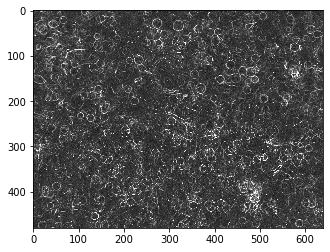

In [4]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

Image = rgb2gray(Image)    
plt.imshow(Image, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)

In [5]:
print (Image.shape)

(480, 640)


###Init variables

`MaxSize` - max size of square region

`MinSize` - min size of square region

`Contrast` - scalar set contrast of recognizing ring 
`Thick` - thickness of ring
`FoundCircles` - numpy array of centers and radiuces (3,None)

In [0]:
firstX=1
firstY=1
ImageSize = (48,90) #Image.shape
MaxSize = 40 
MinSize = 10
Contrast = .18
Variance = 0.03
Thick = .8
FoundCircles = np.array([0,3])
_DEBUG_=False

In [0]:
# from scipy.spatial import distance
# for i in range(0,a.shape[0]):
#   d = [np.sum((a[i]-a[j])**2) for j in range(i+1,a.shape[0])] 
#   print(d) 

###function isCircleFound
calculate average brightness over all pixels of current square;
If pixels of SelectedRing have avg brightness more then avg brightness over all square - circle is found 


In [0]:
#from scipy.special import softmax

def isCircleFound(_box, _mask):
  
  brightness = (lambda arr: np.average(arr-np.min(_box)))#/(np.max(arr)-np.min(box))))
  if _DEBUG_:
    print (brightness(_box[_mask]))
    print (brightness(_box[~_mask]))
  if ((brightness(_box[_mask]) - brightness(_box[~_mask])) > Contrast and np.var(_box[_mask]) < Variance):
    print (brightness(_box[_mask]))
    print (brightness(_box[~_mask]))
    print(np.var(_box[_mask]))
    return True
  else:
    return False
  

###function getMask
create square matrix of boolean as a ring of Trues inscribed in a square of Falses

False


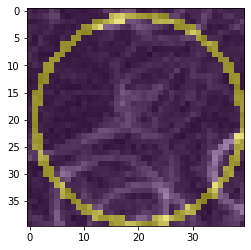

In [22]:
import itertools

def getMask( size, thick = 1 ):
    radius = size //2 - 1
    center = np.array([size/2,size/2])
    vectors = [[(i,j) for j in range(size)] for i in range(size)]
    l = itertools.chain.from_iterable(zip(*vectors))
    
    # list of pairs (x,y) belong of ring
    selectedVecs = np.array(list(filter(lambda v: np.abs(np.linalg.norm(v - center) - radius) < thick,l)))
    
    #ring mask
    ring = np.array(np.zeros((size,size),dtype=np.bool))
    for (i,j) in (selectedVecs):
      ring[i,j]=True
    
    return ring

Mask = getMask( MaxSize, .8 )
square = Image[firstY:firstY+MaxSize, firstX:firstX+MaxSize]
    
#ring visualisation
fig, ax = plt.subplots()
ax.imshow(square, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax.imshow(getMask( MaxSize, .8 ),alpha=.5)
fig.show()
print (isCircleFound(square, Mask))

### function FuzzyCircleConv

In [0]:
import numpy.ma as ma

def FuzzyCircleConv(_box, _mask):
  # return sum(np.dot(_box,_mask))
  mlt = np.multiply(_box,_mask)
  return np.sum(mlt)#/ np.var(ma.masked_values(mlt, 0.0 ))
  

###function getKernel

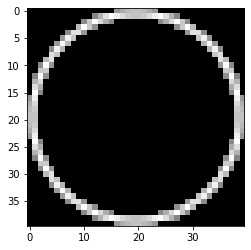

In [26]:
import itertools
import numpy as np
import random as rn
    # size=40 
    # thick = 1
MaxPix = np.max(Image)
MinPix = np.min(Image)

def getKernel( size, thick = 1. ):
    radius = size //2-1
    center = np.array([size/2-.5,size/2-.5])
    vectors = [[(i,j, thick - np.abs(np.linalg.norm((i,j) - center) - radius)) for j in range(size)] for i in range(size)]
    l = itertools.chain.from_iterable(zip(*vectors))
    
    # list of pairs (x,y) belong of ring
    selectedVecs = np.array(list(filter(lambda v: v[2] > 0. ,l)))
    #ring mask
    ring = np.ones((size,size), dtype=np.float32) #np.random.rand(size,size)
    # print(selectedVecs.T[2])
    # print(np.max(selectedVecs.T[2]))
    maxMask= np.max(selectedVecs.T[2])
    ring = -(ring - MinPix)/(MaxPix-MinPix)
    
    for (i,j,k) in (selectedVecs):
      ring[np.int(i),np.int(j)]=k/maxMask

    return ring
plt.imshow(getKernel(40,1),cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)


###One example of arbitrary ring

Conv value: -0.23938815451312112


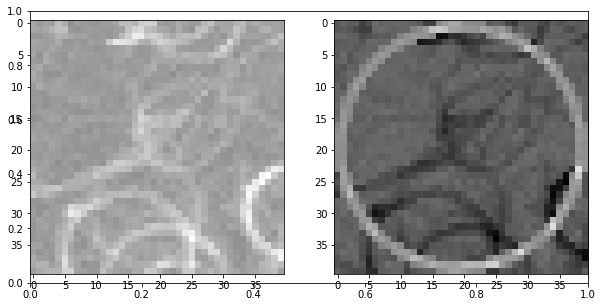

In [11]:
Mask = getKernel( MaxSize, 1 )
square = Image[firstY:firstY+MaxSize, firstX:firstX+MaxSize]
    
#ring visualisation
#ring visualisation
fig, ax = plt.subplots(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.imshow(square, cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)

ax1=fig.add_subplot(1,2,2)

ax1.imshow(np.multiply(square,Mask), cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)
fig.show()
print('Conv value:',FuzzyCircleConv(square,Mask)/MaxSize**2)


###One example of founded ring

conv value -0.08034258328586487


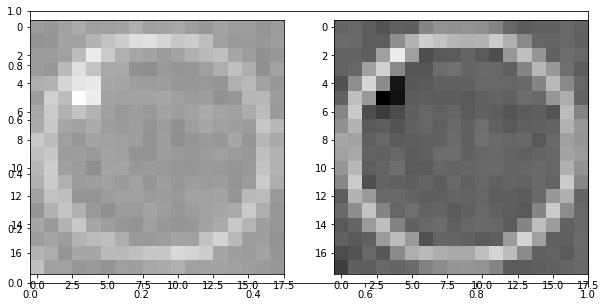

In [12]:
#SquareSize=20, (x,y)= 57, 13

x=58
y=13
size=18
Mask = getKernel( size, 1 )
square = Image[y:y+size, x:x+size]
    
#ring visualisation
fig, ax = plt.subplots(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.imshow(square, cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)

ax1=fig.add_subplot(1,2,2)
#ax1.imshow(square, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
#ax1.imshow(Mask,alpha=.5)
ax1.imshow(np.multiply(square,Mask), cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)
fig.show()
print('conv value', FuzzyCircleConv(Mask,square)/size**2)
#print(FuzzyCircleConv(square,Mask))
# _DEBUG_=True
# print(isCircleFound(square, Mask))
# print(np.var(square[Mask]))
# _DEBUG_=False

###Try classic convolutions

conv value -0.12937657019172136
-0.12937657019172139


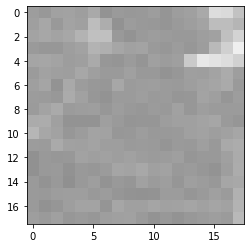

In [35]:
  
  SquareSize=18
  Thick=1
  kernel=getKernel( SquareSize, Thick )
  kernel_size =kernel.shape[0]
  pad_size = kernel_size // 2
  rest = kernel_size % 2
  horisontal_pad = np.random.rand(ImageSize[0], pad_size)#, dtype=np.float64)
  vertical_pad = np.zeros((pad_size, ImageSize[1]+pad_size*2), dtype=np.float64)
  a = np.hstack((horisontal_pad, Image[:ImageSize[0],:ImageSize[1]], horisontal_pad))
  a = np.vstack((vertical_pad, a, vertical_pad))

  sub_shape = kernel.shape
  view_shape = (ImageSize[0]+ rest,ImageSize[1]+ rest, sub_shape[0] , sub_shape[1] )
  strides = a.strides + a.strides
  sub_matrices = np.lib.stride_tricks.as_strided(a,view_shape,strides)
  #arbirtary region
  square = sub_matrices[pad_size,pad_size,:,:]
  plt.imshow(square,plt.get_cmap('gray'), vmin=-1, vmax=1)
  print('conv value', FuzzyCircleConv(square,kernel)/kernel_size**2)
  m=np.sum(np.multiply(sub_matrices,kernel), axis=(2,3))/(kernel_size**2)
  # m = np.sum(np.multiply(square))/(kernel_size**2)
  print(m[pad_size,pad_size])  

In [14]:
sub_matrices.shape

(48, 90, 18, 18)

conv value -0.08034258328586487
-0.08034258328586488


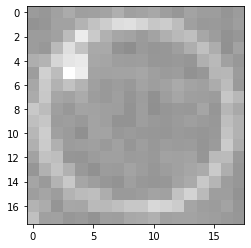

In [36]:
#founded ring
square = sub_matrices[pad_size+13,pad_size+58,:,:]
plt.imshow(square,plt.get_cmap('gray'), vmin=-1, vmax=1)
print('conv value', FuzzyCircleConv(square,kernel)/kernel_size**2)
m=np.sum(np.multiply(sub_matrices,kernel), axis=(2,3))/(kernel_size**2)

print(m[pad_size+13,pad_size+58])

In [37]:
sub_matrices.shape


(48, 90, 18, 18)

In [0]:
#https://stackoverflow.com/questions/43086557/convolve2d-just-by-using-numpy
def conv(_kernel):
  # _kernel = getKernel( size, Thick )
  kernel_size = _kernel.shape[0]
  pad_size = kernel_size // 2
  rest = 0#kernel_size % 2
  horisontal_pad = np.random.rand(ImageSize[0], pad_size)#, dtype=np.float64)
  vertical_pad = np.zeros((pad_size, ImageSize[1]+pad_size*2), dtype=np.float64)
  a = np.hstack((horisontal_pad, Image[:ImageSize[0],:ImageSize[1]], horisontal_pad))
  a = np.vstack((vertical_pad, a, vertical_pad))

  sub_shape = (_kernel.shape)
  view_shape = (ImageSize[0]+ rest,ImageSize[1]+ rest, sub_shape[0] , sub_shape[1] )
  strides = a.strides + a.strides
  sub_matrices = np.lib.stride_tricks.as_strided(a,view_shape,strides)


  # m=np.sum(np.multiply(sub_matrices,_kernel), axis=(2,3))/(kernel_size**2)
  m = np.einsum('ij,klij->kl',_kernel,sub_matrices)/kernel_size**2
  return m
  

### try masqueraded convolutions

In [49]:
mask = getMask( 18, 1 )
print(np.average(sub_matrices[:,:,mask],axis=2).shape)
print(np.min(sub_matrices,axis=(2,3)).shape)

(48, 90)
(48, 90)


In [0]:
#https://stackoverflow.com/questions/43086557/convolve2d-just-by-using-numpy
def mask_conv(_mask):
  # _mask = getKernel( size, Thick )
  mask_size = _mask.shape[0]
  pad_size = mask_size // 2
  rest = 0#mask_size % 2
  horisontal_pad = np.random.rand(ImageSize[0], pad_size)#, dtype=np.float64)
  vertical_pad = np.zeros((pad_size, ImageSize[1]+pad_size*2), dtype=np.float64)
  a = np.hstack((horisontal_pad, Image[:ImageSize[0],:ImageSize[1]], horisontal_pad))
  a = np.vstack((vertical_pad, a, vertical_pad))

  sub_shape = (_mask.shape)
  view_shape = (ImageSize[0]+ rest,ImageSize[1]+ rest, sub_shape[0] , sub_shape[1] )
  strides = a.strides + a.strides
  sub_matrices = np.lib.stride_tricks.as_strided(a,view_shape,strides)
  
  brightness = (lambda arr, msk: np.average(arr[:,:,msk],axis=2)-np.min(arr,axis=(2,3)))#/(np.max(arr)-np.min(box))))
  
  m = (brightness(sub_matrices,_mask) - brightness(sub_matrices,~_mask))/(mask_size * np.var(sub_matrices[:,:,_mask],axis=2)) / np.var(sub_matrices,axis=(2,3)) # > Contrast #and np.var(_box[_mask]) < Variance):
  

  # m=np.sum(np.multiply(sub_matrices,_mask), axis=(2,3))/(mask_size**2)
  # m = np.einsum('ij,klij->kl',_mask,sub_matrices)/mask_size**2
  return m
  

In [88]:
ConvMatrices = np.empty((0,ImageSize[0],ImageSize[1]))
for size in range(MinSize,MaxSize):
  mask = getMask( size, 0.8 )
  #print('size '+str(size))
  res = mask_conv(mask)
  ConvMatrices= np.concatenate((ConvMatrices, np.reshape(res,(1,ImageSize[0],ImageSize[1]))),axis=0)

  # x=58
  # y=13
  # size=18
  # Thick= 1
  # conv value -0.08034258328586487
print(ConvMatrices[18-MinSize,pad_size+12,pad_size+57])
print(ConvMatrices[18-MinSize,pad_size,pad_size])
# for y in range(0,ImageSize[0]-size):
    # for x in range(0, ImageSize[1] - size):
    #   square = Image[y:y+size, x:x+size]
    #   ConvMatrices[y,x, size - MinSize] = FuzzyCircleConv(square,mask)
    #   # fig, ax = plt.subplots()
    #   # ax = fig.add_subplot(1,2,1)
    #   # ax.imshow(square, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    #   # ax1=fig.add_subplot(1,2,2)
    #   # ax1.imshow(square, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    #   # ax1.imshow(mask,alpha=.5)
    #   # fig.show()
    #   # print([(x,y),size])
      

    

22.44041422908184
3.5390957989719114


In [53]:
print(ConvMatrices.shape)

(30, 48, 90)


In [0]:
# outfile = TemporaryFile()
np.save('ConvMatrices', ConvMatrices)

### Main loops


size:  10
5 5 414.5891669234
6 5 713.2759733708211
10 5 29.655103781973622
11 5 83.16779916481086
12 5 73.45843108110891
13 5 35.01677329459351
18 5 91.12896021330029
19 5 85.84877254605333
20 5 39.72316453028035
24 5 27.87814380331899
42 5 167.8489841830059
43 5 212.12152018474566
44 5 143.8749594622374
5 6 30.67780148870201
8 6 144.63535105926823
11 6 88.79399356516963
12 6 31.767016198013334
16 6 28.790665096515383
17 6 45.89782776962941
18 6 40.24478736637097
19 6 28.814002073113375
30 6 123.79402261961422
31 6 112.1285463679767
35 6 38.63411449452742
36 6 75.5035955432364
37 6 260.22139226234344
5 7 109.38800155721215
7 8 242.56851678807953
7 9 38.268579907686075
8 10 23.112926981245433
6 11 106.933817983683
6 12 91.22134442772192
5 13 25.62162865085815
6 14 69.07568515571478
5 15 62.010327039778396
5 16 29.62415912975404
5 17 24.10513881295619
23 18 41.48193552233199
24 19 24.993916131264665
13 20 26.879322831139444
16 21 23.770883736003984
18 22 33.50196830378664
18 23 33.330328

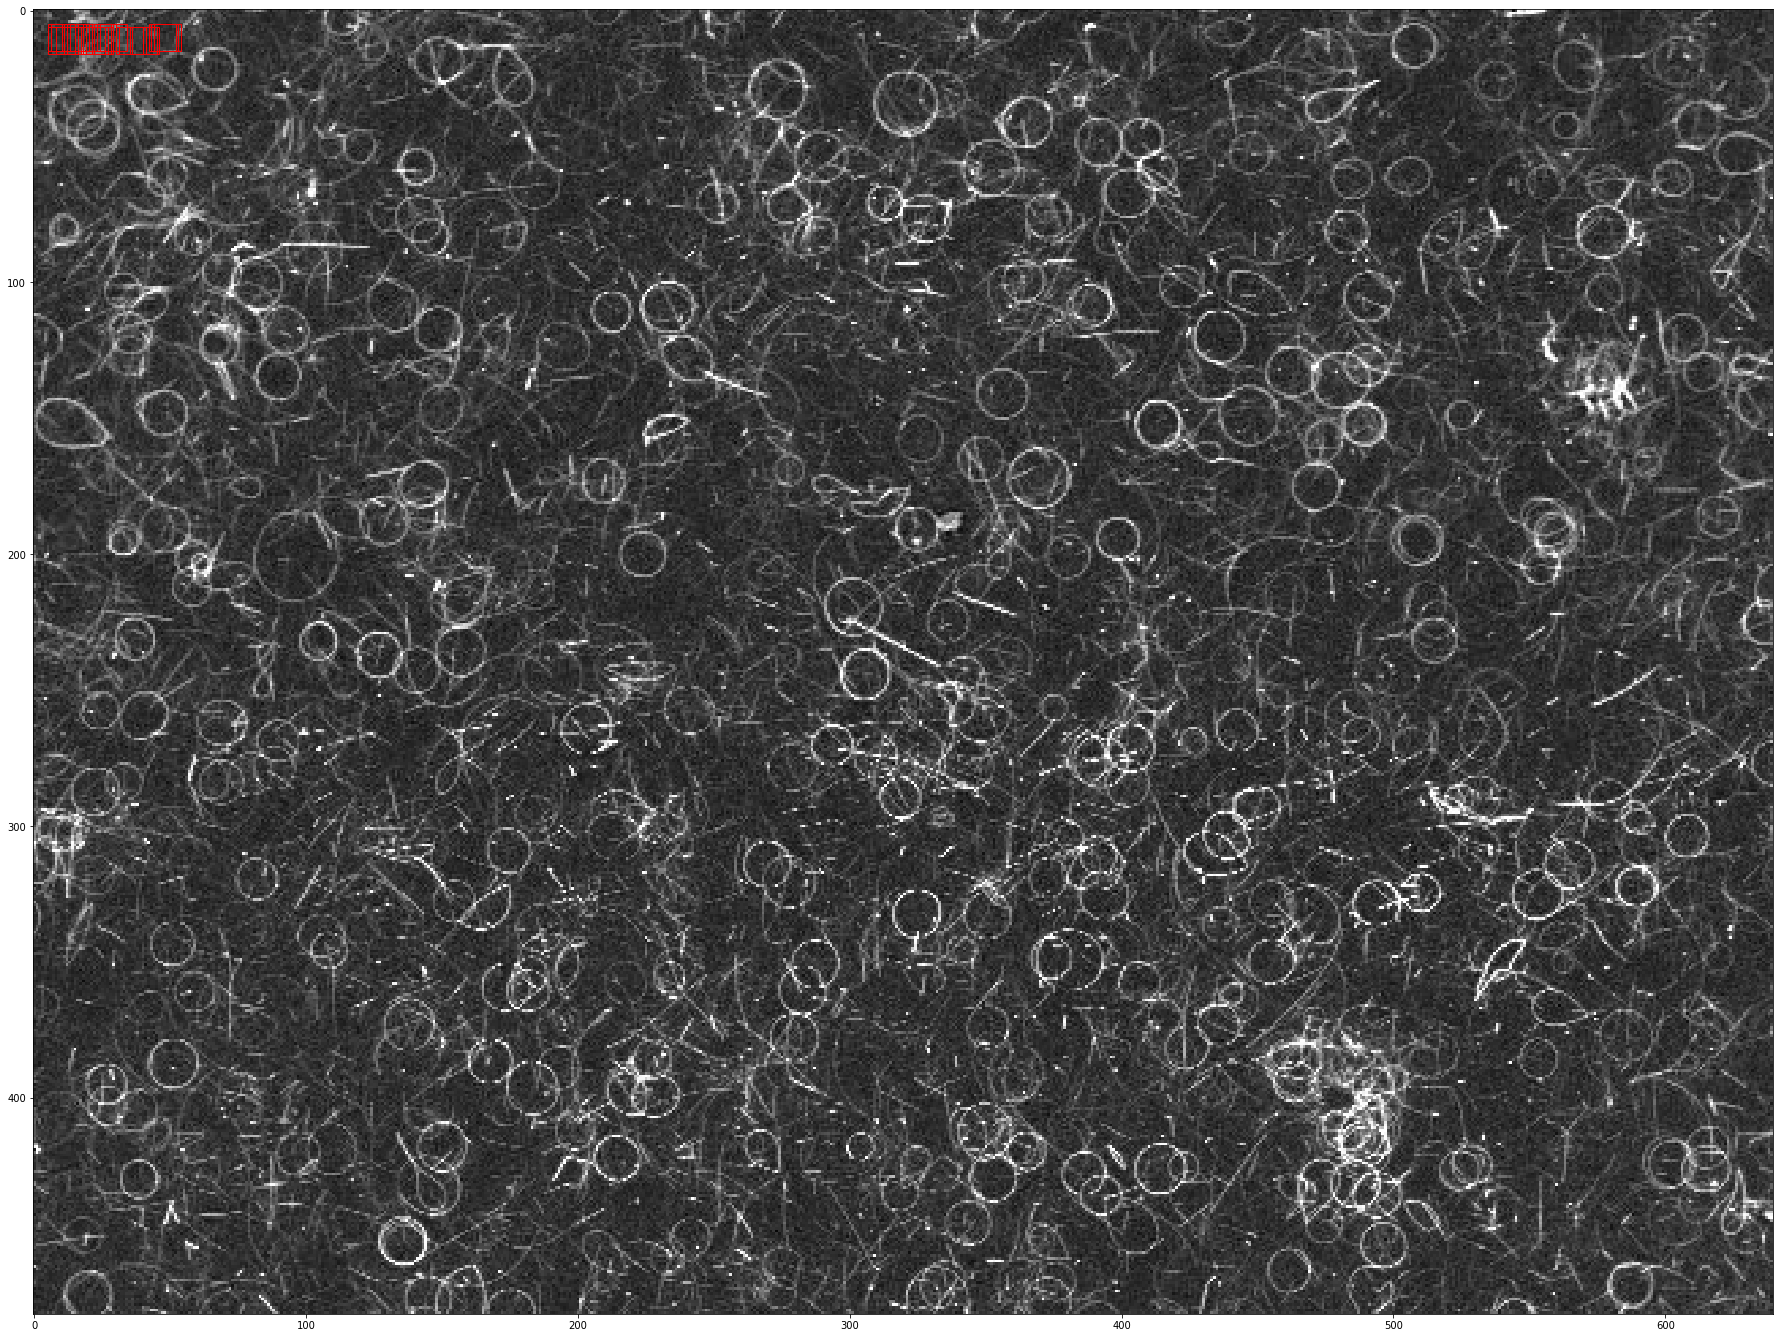

In [89]:
Contrast=0.17
import matplotlib.patches as patches
# plt.ioff()
fig, ax = plt.subplots(figsize=(32, 24))
ax.imshow(Image,cmap=plt.get_cmap('gray') )
# Create a Rectangle patch

cnt=0
for size in range(MinSize,MaxSize):
  print('size: ',size)
  convs = ConvMatrices[size-MinSize,size//2:-size//2,size//2:-size//2]
  for i in range(size//2,convs.shape[0]-size//2):
    y= i 
    for j in range(size//2, convs.shape[1]-size//2):
      x = j 
      if (convs[i,j]>22):
        print(x, y, convs[i,j])
        cnt+=1
        if (cnt>25):
          break
        rect = patches.Rectangle((x,y),size,size,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
plt.show()